In [3]:
# imports 
from numpy import quantile, random, where
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from datetime import datetime, timedelta
from sklearn.datasets import make_blobs
from collections import defaultdict
from sklearn.utils import resample
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from dotenv import load_dotenv
from scipy.stats import zscore
from numpy import average
import seaborn as sns
import pandas as pd
import numpy as np
import threading
import math
import os

In [4]:
# set working directory 
load_dotenv()
os.chdir(os.getenv('DEFAULT_PATH'))

print('In Predictive Model Folder:', os.getcwd())

In Predictive Model Folder: C:\Users\ashly\OneDrive\Documents\Education Material\ResearchProject\MaternalHealthResearch\predictive-model


## Isolation Forest implementation to detect anomalies in heart rate 
# Overview: 
- Group analysis by id's to provide individualistic anomaly tracking
- View resting and activity level anomalies (0,1,2,3) 
- Plot a time series plot for representation of anomalies over time
- Heatmap visualization for correlation in manual input data

# Step 1: Determine Resting Heart Rate of each unique ID on different days

In [6]:
def process_id(df, id_, rhr, minutes):
    date_df = df[df['id'] == id_]
    prev_time = None
    curr_bpm = []
    num_bpm = 0
    for index, row in date_df.iterrows():
        time_ = row['time']
        date_ = row['date']
        bpm_ = row['bpm']
        
        if prev_time is not None: # contains a previous time value
            if (time_ - prev_time <= minutes): # use of couple minute interval due to inconsistent one minute interval times
                num_bpm += 1
                curr_bpm.append(bpm_)
            else:
                num_bpm = 0
                curr_bpm = []
        else: # first initial time
            curr_bpm.append(bpm_)
            num_bpm += 1

        if num_bpm == 5:
            avg_bpm = sum(curr_bpm) // num_bpm  # calculate the avg mean in the interval
            rhr[id_][date_] += avg_bpm
            rhr[id_][date_] //= 2
            num_bpm = 0 # restart the interval amount
            curr_bpm = []

        prev_time = time_ # previous should always be moved to current

def findRestingHeartRate():
    df = pd.read_csv('data_interim/heartrate_mets_intensities_merged_inner.csv')
    df = df[(df['mets'] == 10) & (df['intensity_level'] == 0)]
    rhr = defaultdict(dict)
    
    date_column = []
    time_column = []
    for index,row in df.iterrows():
        dt_object = datetime.strptime(row['timestamp'], "%m/%d/%Y %I:%M:%S %p")
        date_part = dt_object.date()
        date_column.append(date_part)
        time_column.append(dt_object)
        rhr[row['id']][date_part] = 0
        
    df['date'] = date_column
    df['time'] = time_column
    minutes = timedelta(minutes=15) # viewing resting heartrate within a larger interval due to fitbit data frequency of readings
    threads = []
    for id_ in df['id'].unique():
        thread = threading.Thread(target=process_id, args=(df, id_, rhr, minutes))
        threads.append(thread)
        thread.start()

    for thread in threads:
        thread.join()
    
    data = [{'id': id_, 'date': date, 'resting_heart_rate': value} 
        for id_, dates in rhr.items()
        for date, value in dates.items()]
    new_df = pd.DataFrame(data)
   
    # normalize columns containing 0
    d = {}
    avg_group = new_df.groupby('id')
    for id_, group in avg_group:
        avg_rhr = 0
        count = 0
        for hr in list(group['resting_heart_rate']):
            avg_rhr += hr
            count += 1 if hr != 0 else 0
            
        avg_rhr /= count
        d[id_] = avg_rhr
    
    for index, row in new_df.iterrows():
        if row['resting_heart_rate'] <=10:
            new_df.at[index, 'resting_heart_rate'] = d[row['id']]
            
    # Create a Day Column
    start_date = datetime(2016, 4, 12)
    interval = timedelta(days=1)
    date_dict = {}
    current_date = start_date
    for i in range(1,33):
        formatted_date = current_date.strftime('%Y-%m-%d')
        date_obj = datetime.strptime(formatted_date, '%Y-%m-%d').date()
        date_dict[date_obj] = i
        current_date += interval
        
    day_column = []     
    for index, row in new_df.iterrows():
        if row['date'] in date_dict:
            day_column.append(date_dict[row['date']])
        else:
            print('Type Error')
    
    new_df['day'] = day_column
    
    new_df.to_csv('data_interim/daily_resting_heartrate.csv', index=False)
    print(new_df.head())


In [7]:
findRestingHeartRate()

           id        date  resting_heart_rate  day
0  2022484408  2016-04-12                69.0    1
1  2022484408  2016-04-13                66.0    2
2  2022484408  2016-04-14                57.0    3
3  2022484408  2016-04-15                63.0    4
4  2022484408  2016-04-16                60.0    5


C:\Users\ashly\AppData\Local\Temp\ipykernel_5512\2116874974.py:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '74.22727272727273' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_df.at[index, 'resting_heart_rate'] = d[row['id']]


# Step 2: Build the model to determine anomaly classifications
Next Steps: 
1. Add Risk Levels based on the Std of Anomaly classifications and resting heart rate
2. Determine the likelihood of concerns based on the anomaly fluctuation (How stress affects, food intake etc. describe why those anomalies are there to reduce the chances it's an alarming anomaly)
3. Determine the outgoing message based on risk levels

In [14]:
def generateAnomalies(): 
    df = pd.read_csv('data_interim/heartrate_mets_intensities_merged_inner.csv')
    df = df[df['intensity_level'] == 0] # only viewing resting anomalies
    analysis_file = open('reports/anomaly_analysis.txt', 'w')
    day_timestamp = pd.to_datetime(df['timestamp'])
    day_timestamp = day_timestamp.dt.day
    df['day'] = day_timestamp 
    grouped = df.groupby(['id','day'])
    anomalies = {}
    example = True
    for (id, day), group in grouped:
        X = group[['bpm','mets']].values
        
        ## Isolation Forest
        model = IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.1),max_features=1.0)
        model.fit(X)
        anomaly_scores = model.decision_function(X)
        anomaly_scores_reshaped = anomaly_scores.reshape(-1, 1)
        scaler = MinMaxScaler(feature_range=(-1, 1))
        anomaly_scores_scaled = scaler.fit_transform(anomaly_scores_reshaped)
        anomaly_scores_scaled = anomaly_scores_scaled.flatten()
        group['if_anomaly_score'] = anomaly_scores_scaled
        group['if_anomaly'] = model.predict(X)
        
        ## Local Outlier Factor
        if len(X) > 1: # skip over id/days containing 0
            N = len(X)-1 if len(X) < 20 else 20
            lof = LocalOutlierFactor(n_neighbors=N)
            lof_anomaly_scores = lof.fit_predict(X)
            group['lof_anomaly'] = lof_anomaly_scores
            outlier_scores = lof.negative_outlier_factor_
            outlier_scores_reshaped = outlier_scores.reshape(-1, 1)
            scaler = MinMaxScaler(feature_range=(-1, 1))
            outlier_scores_scaled = scaler.fit_transform(outlier_scores_reshaped)
            outlier_scores_scaled = outlier_scores_scaled.flatten()
            group['lof_anomaly_score'] = outlier_scores_scaled
        
        anomalies[(id, day)] = group
        
        if example:
            example = False
            # Plot Isolation Forest
            # Plot Timestamp and Heart Rate Relation
            plt.figure(figsize=(10,8))
            hour = [datetime.strptime(t, "%m/%d/%Y %I:%M:%S %p").hour for t in group['timestamp']]
            plt.scatter(hour, X[:, 0], c=anomaly_scores_scaled, cmap='cool', edgecolor='k')
            plt.colorbar(label='Anomaly Score')
            plt.title(f'Isolation Forest Anomaly Detection DAY: {day} ID: {id}')
            plt.xlabel('Timestamp (Hour)', fontsize=18)
            plt.ylabel('Heart Rate (BPM)', fontsize=18)
            plt.show()

            # Plot Heart Rate and METs Relation
            plt.figure(figsize=(10,8))
            plt.scatter(X[:, 0], X[:, 1], c=anomaly_scores_scaled, cmap='cool', edgecolor='k')
            plt.colorbar(label='Anomaly Score')
            plt.title(f'Isolation Forest Anomaly Detection DAY: {day} ID: {id}')
            plt.xlabel('Heart Rate (BPM)', fontsize=18)
            plt.ylabel('METs', fontsize=18)
            plt.show()

            # Plot Timestamp and BPM relation
            plt.figure(figsize=(10,8))
            hour = [datetime.strptime(t, "%m/%d/%Y %I:%M:%S %p").hour for t in group['timestamp'][lof_anomaly_scores == 1]]
            plt.scatter(hour, X[lof_anomaly_scores == 1][:, 0], color='pink', s=50, label='Inliers')
            hour = [datetime.strptime(t, "%m/%d/%Y %I:%M:%S %p").hour for t in group['timestamp'][lof_anomaly_scores == -1]]
            plt.scatter(hour, X[lof_anomaly_scores == -1][:, 0], color='darkred', s=50, label='Outliers')
            plt.legend(title='Legend', loc='upper left', fontsize='large')
            plt.rcParams.update({'font.size': 18})
            plt.rcParams['font.family'] = 'Times New Roman'
            plt.title(f'Local Outlier Factor DAY: {day} ID: {id}')
            plt.xlabel('Timestamp (Hour)', fontsize=18)
            plt.ylabel('Heart Rate (BPM)', fontsize=18)
            plt.legend()
            plt.show()

            # Plot METS and BPM relation
            plt.figure(figsize=(10,8))
            plt.scatter(X[lof_anomaly_scores == 1][:, 0], X[lof_anomaly_scores == 1][:, 1], color='pink', s=50, label='Inliers')
            plt.scatter(X[lof_anomaly_scores == -1][:, 0], X[lof_anomaly_scores == -1][:, 1], color='darkred', s=50, label='Outliers')
            plt.legend(title='Legend', loc='upper left', fontsize='large')
            plt.rcParams.update({'font.size': 18})
            plt.rcParams['font.family'] = 'Times New Roman'
            plt.title(f'Local Outlier Factor DAY: {day} ID: {id}')
            plt.xlabel('Heart Rate (BPM)', fontsize=18)
            plt.ylabel('METS', fontsize=18)
            plt.legend()
            plt.show()
    
    # Almost Identical Outcomes
    # for (id,intensity_level, day), anomaly_group in anomalies.items():
    #     plt.figure(figsize=(10, 8))
        
    #     # Filter anomaly and non-anomaly data
    #     isanomaly = anomaly_group[(anomaly_group['if_anomaly'] == -1) & (anomaly_group['if_anomaly_score'] < 0)]
    #     nonanomaly = anomaly_group[(anomaly_group['if_anomaly'] == 1) & (anomaly_group['if_anomaly_score'] >= 0)]
        
    #     # Plot Non Anomalies
    #     hour = [datetime.strptime(t, "%m/%d/%Y %I:%M:%S %p").hour for t in nonanomaly['timestamp']]
    #     plt.scatter(hour, nonanomaly['bpm'], color='pink', label='Non Anomaly Heart Rate (BPM)')
    
    #     # Plot Anomalies
    #     hour = [datetime.strptime(t, "%m/%d/%Y %I:%M:%S %p").hour for t in isanomaly['timestamp']]
    #     plt.scatter(hour, isanomaly['bpm'], color='darkred', label='Anomaly Heart Rate (BPM)')
        
    #     plt.legend(loc='upper left', fontsize='large')
    #     plt.rcParams.update({'font.size': 18})
    #     plt.rcParams['font.family'] = 'Times New Roman'
    #     plt.xlabel('Timestamp',fontsize=18)
    #     plt.ylabel('Heart Rate (BPM)',fontsize=18)
    #     plt.title(f'Time Series Plot Day: {day} with Anomalies (ID: {id}) (Intensity Level: {intensity_level})')
    #     plt.show()
    #     break

    # store the individual anomalies into a dataframe
    dataframes = []
    for key, value in anomalies.items():
        df_anomalies = pd.DataFrame()
        df_anomalies['id'] = value['id']
        df_anomalies['timestamp'] = value['timestamp']
        df_anomalies['day'] = value['day']
        # df_anomalies['intensity_level'] = value['intensity_level']
        df_anomalies['mets'] = value['mets']
        df_anomalies['bpm'] = value['bpm']
        df_anomalies['if_anomaly_score'] = value['if_anomaly_score']
        df_anomalies['if_anomaly'] = value['if_anomaly']
        
        if ('lof_anomaly_score' in value) and ('lof_anomaly' in value):
            df_anomalies['lof_anomaly_score'] = value['lof_anomaly_score']
            df_anomalies['lof_anomaly'] = value['lof_anomaly']
        else:
            size = len(value)
            df_anomalies['lof_anomaly_score'] = np.zeros(size)
            df_anomalies['lof_anomaly'] = np.zeros(size) 
            
        dataframes.append(df_anomalies)
        
        ## Create Document for Group Patterns
        text = f'ID: {key[0]}, DAY: {key[1]} = {value.describe()}'
        analysis_file.write(text)
        
    df_merged = pd.concat(dataframes, ignore_index=True)
    df_merged.to_csv('data_interim/anomalies_heartrate.csv', index=False)
    
    

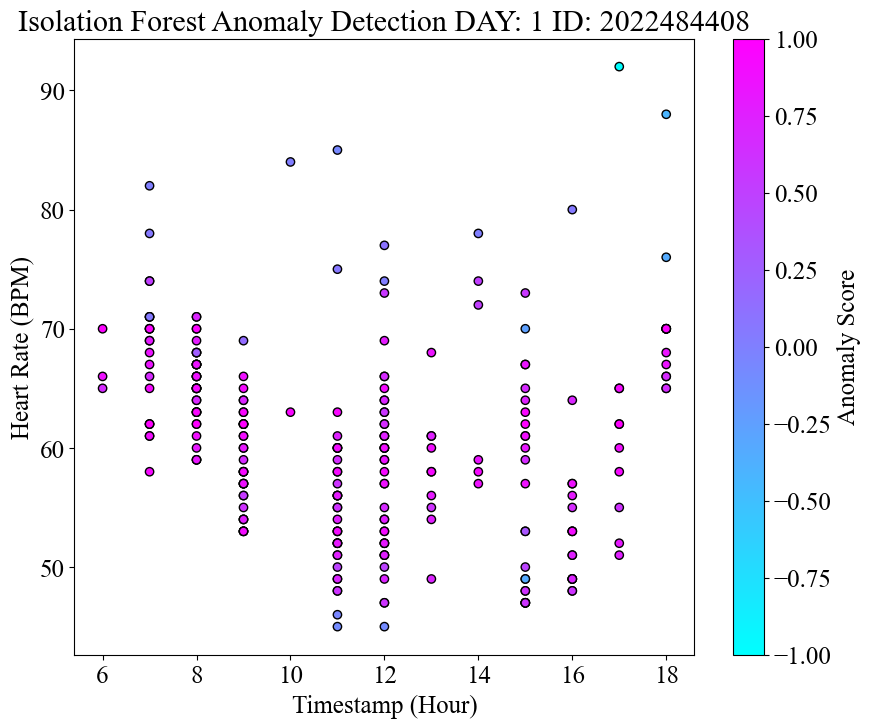

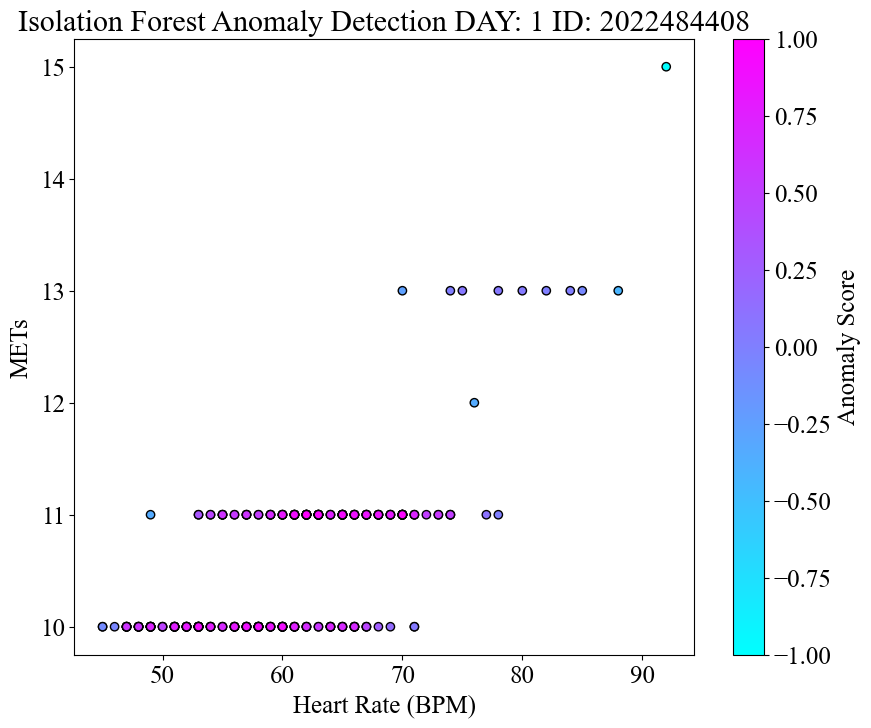

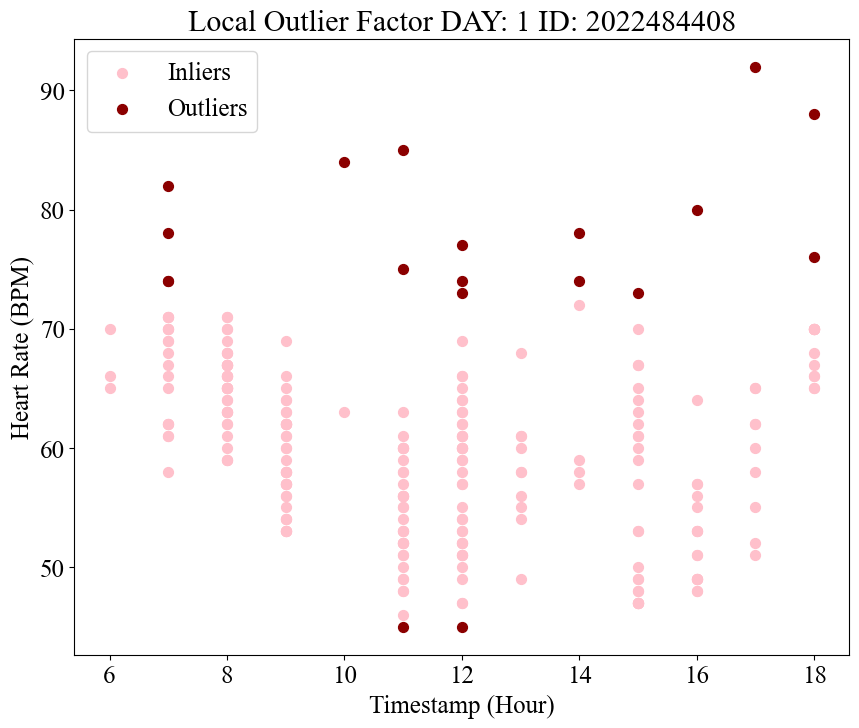

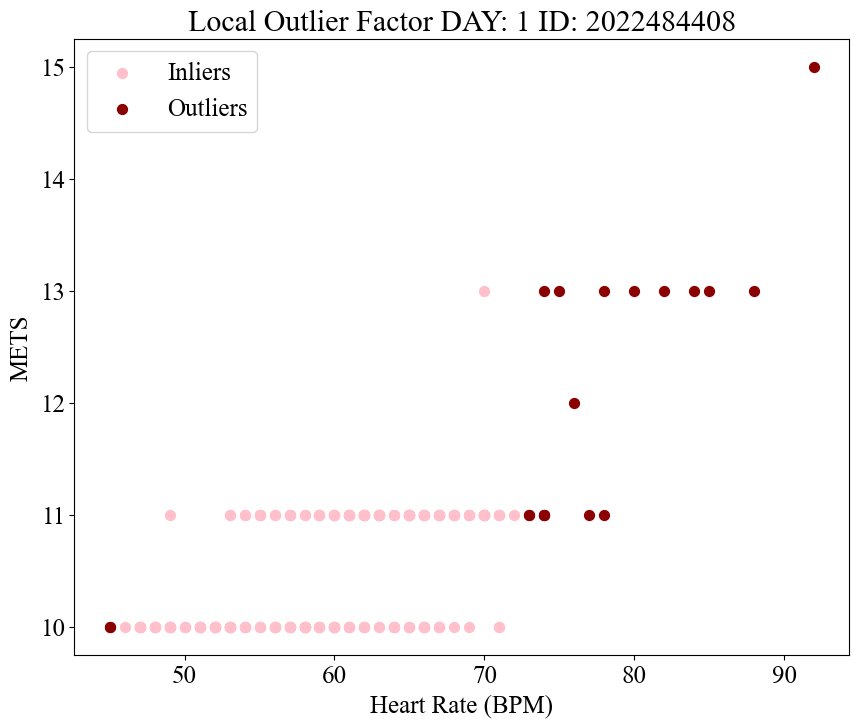

In [15]:
generateAnomalies()

## Step 3: Bin Analysis of Anomalies: Anomaly Score levels to detect low, medium and high risk levels

Risk level is personalized by the given range of anomaly scores consisting of different comparisons for lof and if. Assessment of Risk Levels is dependent on ... 

In [25]:
def DefineRiskLevels():
    df_anomaly = pd.read_csv('data_interim/anomalies_heartrate.csv')
    df_rhr = pd.read_csv('data_interim/daily_resting_heartrate.csv')

    # store rhr into a dictionary
    rhr = {}
    for index, row in df_rhr.iterrows():
        rhr[row['id']] = {row['day']: row['resting_heart_rate']}
    
    # add standard deviation column to anomalies dataset
    std_column = []
    for index, row in df_anomaly.iterrows():
        if (rhr.get(row['id']), 0) and rhr[row['id']].get(row['day'], 0):
            std_anomaly = abs(rhr[row['id']][row['day']] - row['bpm'])
        elif (rhr.get(row['id']), 0): # contains a different day
            std_anomaly = abs(list(rhr[row['id']].values())[0] - row['bpm']) # take the first resting heart rate available
        else:
            # No Resting Heart Rate Found .. use default 
            print('No Resting Heart Rate Found: Using Default')
            default_rhr = 80
            std_anomaly = abs(default_rhr - row['bpm'])
            
        std_column.append(std_anomaly)
        
    df_anomaly['std_resting_heart_rate'] = std_column 
    print(df_anomaly.head())

    # determine the z_score of anomaly score and bpm for each individual id/day
    stats = {'lof_zscore': [], 'if_zscore': [], 'bpm_zscore': [], 'std_rhr_zscore': []}
    grouped = df_anomaly.groupby(['id','day'])  
    for (id, day), group in grouped:
        ## Create the bins for Low, Medium, High Risk based on the range for anomalies in the dataset
        
        # # minimum values 
        # std_rhr_min = min(group['std_resting_heart_rate'])
        # lof_min = min(group['lof_anomaly_score'])
        # if_min = min(group['if_anomaly_score'])
        # bpm_min = min(group['bpm'])
        
        # # maximum values
        # std_rhr_max = max(group['std_resting_heart_rate'])
        # lof_max = max(group['lof_anomaly_score'])
        # if_max = max(group['if_anomaly_score'])
        # bpm_max = max(group['bpm'])
        
        # # median values
        # lof_med = np.median(group['lof_anomaly_score'])
        # if_med = np.median(group['if_anomaly_score'])
        
        # # mean values
        std_rhr_mean = group['std_resting_heart_rate'].mean()
        lof_mean = group['lof_anomaly_score'].mean()
        if_mean = group['if_anomaly_score'].mean()
        bpm_mean = group['bpm'].mean()

        # # std values
        std_rhr_std = group['std_resting_heart_rate'].std()
        lof_std = group['lof_anomaly_score'].std()
        if_std = group['if_anomaly_score'].std()
        bpm_std = group['bpm'].std()
        
        # z score values 
        # z_scores_limit = np.clip(zscore(group['std_resting_heart_rate']), -2, 2) 
        z_scores = ((group['std_resting_heart_rate'] - std_rhr_mean) / std_rhr_std)
        stats['std_rhr_zscore'].extend(z_scores)
        # z_scores_limit = np.clip(zscore(group['bpm']), -2, 2) 
        z_scores = ((group['bpm'] - bpm_mean) / bpm_std)
        stats['bpm_zscore'].extend(z_scores)
        
        # print(f'IF ZSCORE: {stats['if_zscore']} IF MIN: {if_min} IF MAX: {if_max} IF MEAN: {if_mean} IF MEDIAN: {if_med} IF STD: {if_std}')
        # print(f'LOF ZSCORE: {stats['lof_zscore']} LOF MIN: {lof_min} LOF MAX: {lof_max} LOF MEAN: {lof_mean} LOF MEDIAN: {lof_med} LOF STD: {lof_std}')
        # print(f'BPM ZSCORE: {stats['bpm_zscore']} BPM MIN: {bpm_min} BPM MAX: {bpm_max} BPM MEAN: {bpm_mean} BPM STD: {bpm_std}')
        # print(f'STD ZSCORE: {stats['std_rhr_zscore']} STD MIN: {std_rhr_min} STD MAX: {std_rhr_max} STD MEAN: {std_rhr_mean} STD RHR STD: {std_rhr_std}')
    
        
    df_anomaly['std_rhr_zscore'] = stats['std_rhr_zscore']
    df_anomaly['bpm_zscore'] = stats['bpm_zscore']
    
    # Risk Levels Assigned By Z-Score
    std_rhr_bin = []
    lof_bin = []
    if_bin = []
    bpm_bin = []
    
    for index, row in df_anomaly.iterrows():
        risk_level = lambda x: "Low" if x < 2 else ("Medium" if (x >= 2 and x < 3) else "High")
        model_risk_level = lambda x: "High" if x < -0.25 else ("Medium" if (x >= -0.25 and x < 0.25) else "Low")
        
        # bin values 
        std_rhr_bin.append(risk_level(row['std_rhr_zscore']))
        lof_bin.append(model_risk_level(row['lof_anomaly_score']))
        if_bin.append(model_risk_level(row['if_anomaly_score']))
        bpm_bin.append(risk_level(row['bpm_zscore']))
    
    df_anomaly['std_rhr_bin'] = std_rhr_bin
    df_anomaly['lof_bin'] = lof_bin
    df_anomaly['if_bin'] = if_bin
    df_anomaly['bpm_bin'] = bpm_bin
    df_anomaly.to_csv('data_interim/anomalies_heartrate.csv', index=False)
    
    

In [26]:
DefineRiskLevels()

           id            timestamp  day  mets  bpm  if_anomaly_score  \
0  2022484408  5/1/2016 6:16:00 AM    1    11   70          0.974049   
1  2022484408  5/1/2016 6:52:00 AM    1    11   66          0.860049   
2  2022484408  5/1/2016 6:53:00 AM    1    10   65          0.665530   
3  2022484408  5/1/2016 7:01:00 AM    1    11   71          0.711387   
4  2022484408  5/1/2016 7:03:00 AM    1    11   70          0.974049   

   if_anomaly  lof_anomaly_score  lof_anomaly  std_resting_heart_rate  \
0           1           0.966541          1.0                    10.0   
1           1           0.927862          1.0                     6.0   
2           1           0.920480          1.0                     5.0   
3           1           0.907700          1.0                    11.0   
4           1           0.966541          1.0                    10.0   

   std_rhr_zscore  lof_zscore  if_zscore  bpm_zscore std_rhr_bin lof_bin  \
0        0.677968    0.372688   0.911647    1.132694

## Step 4: Visualize the Bin Distribution of Anomaly Classifications

In [184]:
def BinDistributionAnalysis(): # Continue tomorrow --> determine the best bin measurement for further alerting (When to be concerned)
    # view the frequency in various risk levels based on bpm amount 
    df_anomaly = pd.read_csv('data_interim/anomalies_heartrate.csv')
    
    ## Results: BPM STD overlap with LOF but with a lower false positive rate, but IF while it has moreso high false positive it detects the lower end better than both threshold analysis methods
    sample = df_anomaly[(df_anomaly['id']==2022484408) & (df_anomaly['day'] == 1)]
    colors = ['darkred' if val =='High' else ('red' if (val == 'Medium') else '#FF000000') for val in sample['std_rhr_bin']]
    colors2 = ['darkred' if val =='High' else ('red' if (val == 'Medium') else '#FF000000') for val in sample['lof_bin']]
    colors3 = ['darkred' if val =='High' else ('red' if (val == 'Medium') else '#FF000000') for val in sample['if_bin']]
    
    point1 = Line2D([0], [0], label='High Risk', marker='o', markersize=10, markeredgecolor='darkred', markerfacecolor='darkred', linestyle='')
    point2 = Line2D([0], [0], label='Medium Risk', marker='o', markersize=10,  markeredgecolor='r', markerfacecolor='r', linestyle='')

    fig, axs = plt.subplots(1, 3, figsize=(22, 5))
    axs[0].plot(sample['timestamp'], sample['bpm'], color='pink')
    axs[0].scatter(sample['timestamp'], sample['bpm'], color=colors)
    axs[0].set_title('Std Resting Heart Rate Risk Level in Comparison to BPM')
    axs[0].set_xticks([])
    axs[0].set_xlabel('Timestamp', fontsize=18)
    axs[0].set_ylabel('BPM', fontsize=18)
    axs[0].legend(handles=[point1 ,point2])
    
    axs[1].plot(sample['timestamp'], sample['bpm'], color='pink')
    axs[1].scatter(sample['timestamp'], sample['bpm'], color=colors2)
    axs[1].set_title('Local Outlier Factor Risk Level in Comparison to BPM')
    axs[1].set_xticks([])
    axs[1].set_xlabel('Timestamp', fontsize=18)
    axs[1].set_ylabel('BPM', fontsize=18)
    axs[1].legend(handles=[point1 ,point2])
    
    axs[2].plot(sample['timestamp'], sample['bpm'], color='pink')
    axs[2].scatter(sample['timestamp'], sample['bpm'], color=colors3)
    axs[2].set_title('Isolation Forest Risk Level in Comparison to BPM')
    axs[2].set_xticks([])
    axs[2].set_xlabel('Timestamp', fontsize=18)
    axs[2].set_ylabel('BPM', fontsize=18)
    plt.legend(handles=[point1 ,point2])
    plt.tight_layout()
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.show()
    
    # BPM Z-SCORE 
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df_anomaly, x='bpm_bin', y='bpm', color='deeppink')
    plt.title('Distribution of BPM Z-Score Classification')
    plt.xlabel('Risk Level', fontsize=18)
    plt.ylabel('BPM', fontsize=18)
    plt.rcParams.update({'font.size': 18})
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.show()
    
    # STD Resting Heart Rate Bin
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df_anomaly, x='std_rhr_bin', y='bpm', color='deeppink')
    plt.title('Distribution of Resting Heart Rate STD Classification')
    plt.xlabel('Risk Level', fontsize=18)
    plt.ylabel('BPM', fontsize=18)
    plt.rcParams.update({'font.size': 18})
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.show()
 
 
    ## Show the way thresholds are classified within the models
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    # Local Outlier Factor 
    sns.boxplot(data=df_anomaly, x='lof_bin', y='lof_anomaly_score', color='darkviolet', ax=axs[0])
    axs[0].set_title('Distribution of Local Outlier Factor Classification')
    axs[0].set_xlabel('Risk Level', fontsize=18)
    axs[0].set_ylabel('Anomaly Score', fontsize=18)
    axs[0].tick_params(axis='both', labelsize=16)

    # IsolationForest
    sns.boxplot(data=df_anomaly, x='if_bin', y='if_anomaly_score', color='darkviolet', ax=axs[1])
    axs[1].set_title('Distribution of Isolation Forest Classification')
    axs[1].set_xlabel('Risk Level', fontsize=18)
    axs[1].set_ylabel('Anomaly Score', fontsize=18)
    axs[1].tick_params(axis='both', labelsize=16)
    plt.tight_layout()
    plt.show()

   

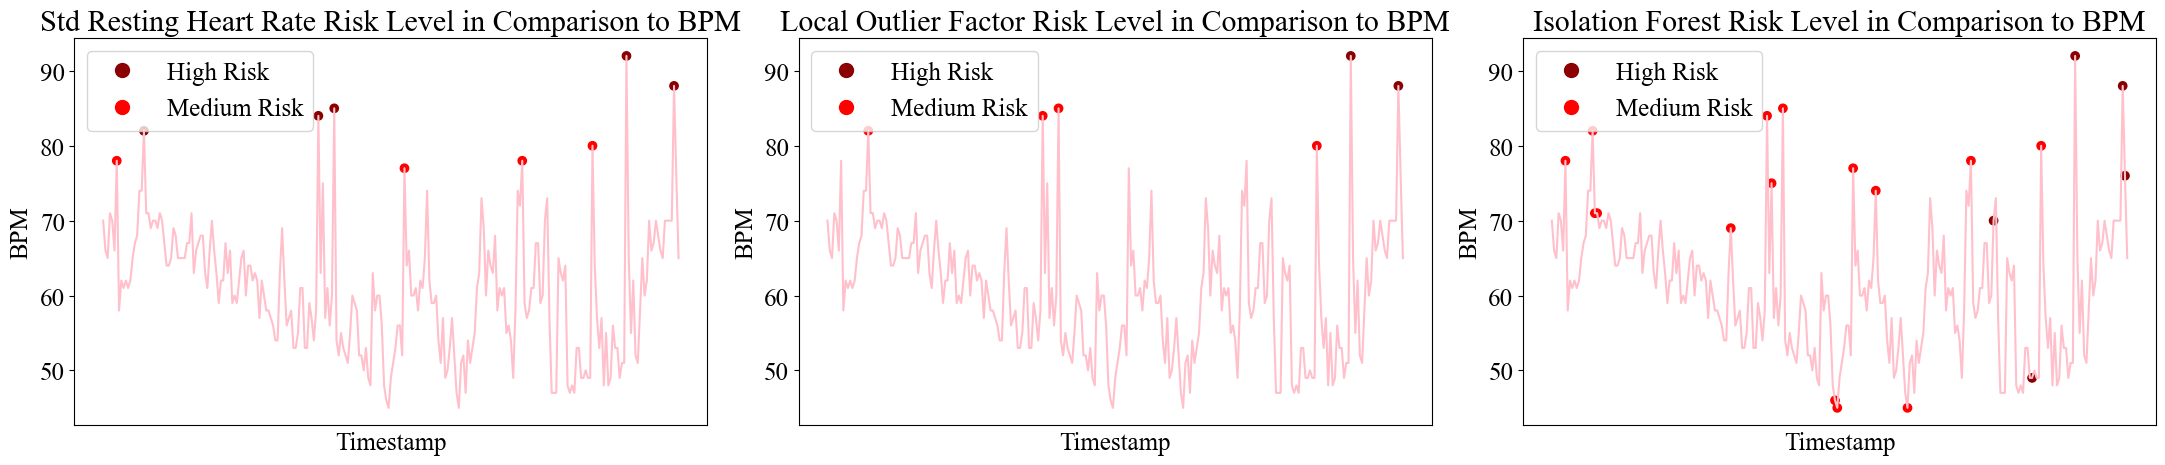

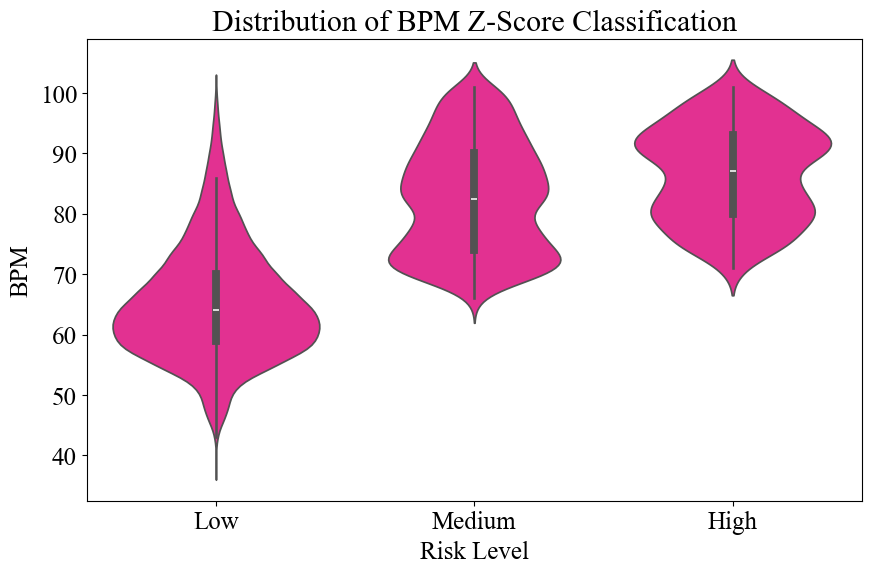

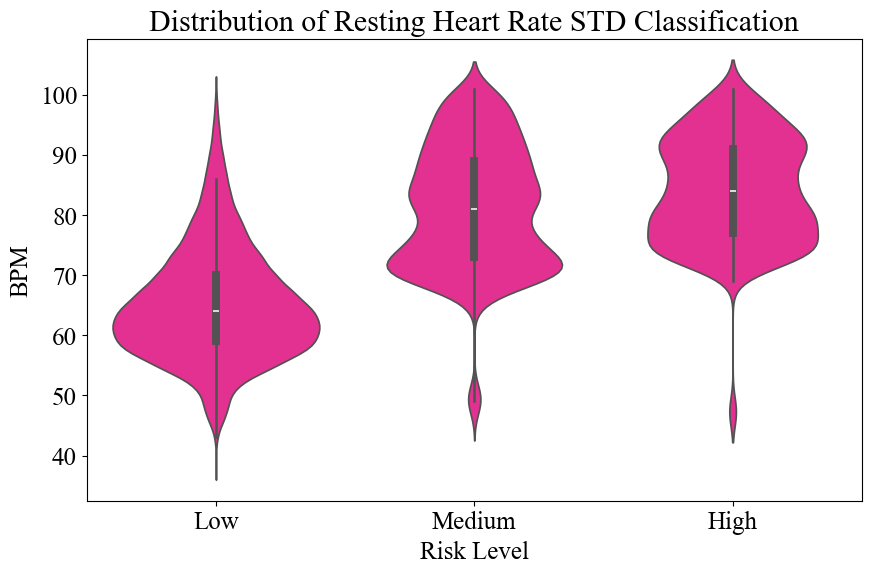

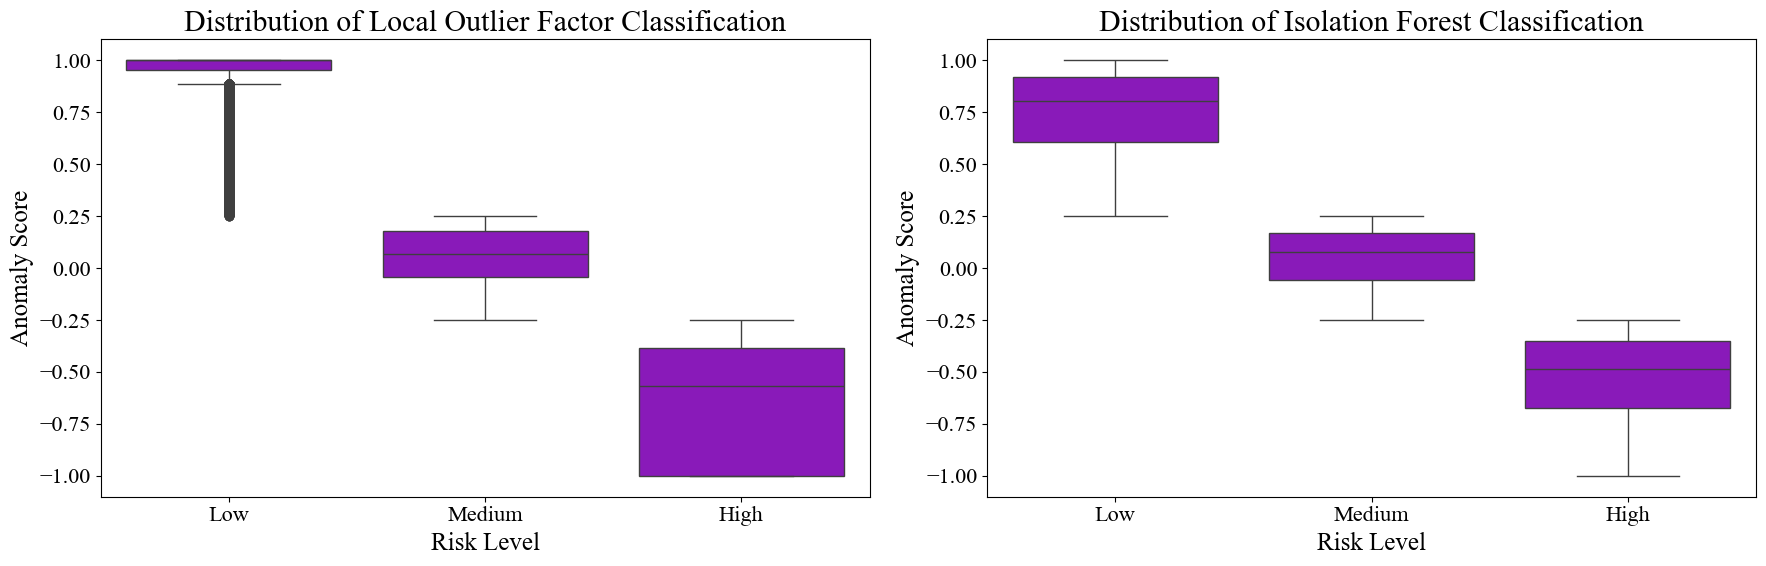

In [185]:
BinDistributionAnalysis()

## Anomaly Score Distribution Graph (Viewing the BPM Values that are viewed as anomalies)

In [7]:
def AnalyzeAnomalyScores():
    df = pd.read_csv('data_interim/anomalies_heartrate_intensities.csv')
    df = df[df['intensity_level'] == 0] # only view resting intensity level anomalies
    
    day_timestamp = pd.to_datetime(df['timestamp'])
    df['day'] = day_timestamp.dt.day
    grouped = df.groupby(['id','day'])
    for (id_,day_), group in grouped:
        plt.figure(figsize=(10, 6)) 
        anomaly_colors = ['red' if anomaly_score >= 0.23 else '#FF000000' for anomaly_score in group['anomaly_score']]
        plt.rcParams['font.family'] = 'Times New Roman'
        plt.scatter(group['timestamp'], group['bpm'], color=anomaly_colors)
        plt.plot(group['timestamp'], group['bpm'], color='deeppink',label='Heart Rate (BPM)')
        plt.rcParams.update({'font.size': 18})
        plt.xlabel('Timestamp',fontsize=18)
        plt.ylabel('BPM',color='deeppink',fontsize=18)
        plt.ylim(min(group['bpm']),max(group['bpm']))
        # plt.gca().xaxis.set_major_locator(plt.MultipleLocator(10))
        plt.xticks([],rotation=45)
        plt.legend(loc='lower left')
        
        plt.twinx()
        plt.plot(group['timestamp'], group['anomaly_score'], color='pink',label='Anomaly Score [-1,1]')
        plt.rcParams.update({'font.size': 18})
        plt.ylabel('Anomaly Score',color='pink',fontsize=18)
        plt.ylim(min(group['anomaly_score']),max(group['anomaly_score']))
        # plt.gca().xaxis.set_major_locator(plt.MultipleLocator(10))
        plt.xticks([],rotation=45)
        
        # add high anomaly threshold markings 
        plt.title(f'Anomaly Score Isolation Forest Distribution: ID: {id_} DAY: {day_}')
        plt.legend(loc='lower right')
        plt.show()
        break

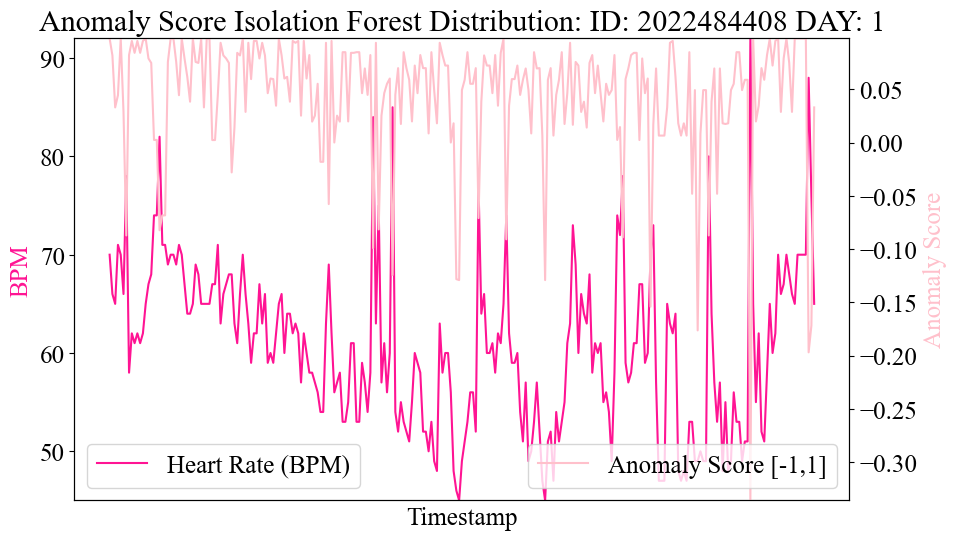

In [8]:
AnalyzeAnomalyScores()

## Step 5: Initialize Protocols for Alerts using Bin Overlaps

In [5]:
def ModelAlerts():
    '''
    Daily Alerts regarding the previous day
    Overlaps in HIGH all Risk Bins (High Level Alert)
    Overlap in MEDIUM all Risk Bins (Medium Level Alert)
    Analysis of Isolation Forest HIGH Low limit concerns
    Less Crucial Notifications may be implemented for Low -> Medium
    '''
    dataframes = []
    df = pd.read_csv('data_interim/anomalies_heartrate.csv')
    grouped = df.groupby(['id', 'day'])
    count = 10
    for (id_, day_), group in grouped:
        # viewing each day for each unique id
        high_values = group[(group['std_rhr_bin'] == 'High') & 
                    (group['lof_bin'] == 'High') & 
                    (group['if_bin'] == 'High')]
        
        med_values = group[(group['std_rhr_bin'] == 'Medium') & 
                    (group['lof_bin'] == 'Medium') & 
                    (group['if_bin'] == 'Medium')]
        
        # view when lower limit anomalies in isolation forest (Future Work Section regarding this use cases)
        low_values = group[(group['std_rhr_bin'] == 'Low') & 
                    (group['lof_bin'] == 'Low') & 
                    (group['if_bin'] == 'High')]
        
        count -=1
        if count <= 0:
            break
        dataframes.append(med_values)
        
    # maybe add in a standard level of error like less than 100 when mets != at rest etc.
        
    df_merged = pd.concat(dataframes, ignore_index=True)
    df_merged.to_csv('data_interim/test.csv', index=False)
        
        

In [6]:
ModelAlerts()